<a href="https://colab.research.google.com/github/TheodoredaCunha/Homemade-GPT-Model/blob/main/GPT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**Loading and Cleaning the Dataset**

In [2]:
import string
import nltk.data
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [3]:
#getting all the filenames that contain the data
TOTAL_CHAPTERS  = 3
dataset = []
for i in range(1, TOTAL_CHAPTERS + 1):
  dataset.append("chapter{}.txt".format(i))

print(dataset)

['chapter1.txt', 'chapter2.txt', 'chapter3.txt']


In [4]:
from os import setpgid

PATH = "drive/MyDrive/gpt/"
VOCAB_SET = set()
VOCAB_DICTIONARY = {}
ALL_CHAPTERS = []
def cleanData(filepath): #lowercase all characters and removing punctuations
  with open(filepath) as f:
    full_chapter = f.read().lower()
    cleaned_chapter = full_chapter.translate (str.maketrans ('', '', string.punctuation)) #remove punctuations from every sentence
    cleaned_split_chapter = cleaned_chapter.split() #turn every sentence into a list of words
    chapter_vocab = set(cleaned_split_chapter) #update the set of unique wordds in this sentence
    ALL_CHAPTERS.append(cleaned_split_chapter) #append the cleaned chapter text to a single list
    VOCAB_SET.update(chapter_vocab) #update the set of unique words for all chapters in the data
    f.close() #close the file
 
def createVocabDictionary(): #fill out vocab_dictionary based on the vocab set
  vocab_list = list(VOCAB_SET)
  for count, word in enumerate(vocab_list): #assign a number to every word in the vocab list
    VOCAB_DICTIONARY[word] = count

'''
IMPLEMENTING THE FUNCTIONS:
'''
#opening and cleaning each chapter
for chapter in dataset:
  print(chapter)
  cleanData(PATH + chapter)

#creating the vocabulary dictionary
createVocabDictionary()

#convert each letter in the chapters into their assigned numbers from the dictionary
for chapter in ALL_CHAPTERS:
  for i in range(len(chapter)):
    chapter[i] = VOCAB_DICTIONARY[chapter[i]]

print(ALL_CHAPTERS[0])

chapter1.txt
chapter2.txt
chapter3.txt
[897, 1776, 354, 2083, 1606, 588, 1342, 274, 1078, 1554, 1850, 962, 1136, 1912, 244, 1554, 227, 526, 1257, 127, 211, 194, 244, 1554, 1545, 1612, 1506, 396, 1814, 962, 873, 69, 528, 1394, 1966, 1296, 1885, 1156, 244, 35, 1883, 754, 958, 1595, 488, 897, 2083, 1667, 1545, 2131, 1606, 2021, 2111, 1895, 1952, 942, 1919, 1953, 431, 1667, 2021, 2050, 1528, 902, 958, 574, 1905, 1255, 1799, 431, 1788, 2157, 2021, 211, 1553, 1911, 354, 2083, 1667, 529, 1776, 1492, 1776, 1158, 1126, 151, 1545, 17, 1934, 1606, 1255, 942, 927, 528, 211, 1416, 282, 1649, 1084, 152, 194, 1606, 926, 60, 430, 448, 109, 1063, 279, 1017, 1545, 724, 1545, 1967, 1158, 2021, 1683, 1432, 1895, 1741, 1776, 528, 1258, 1964, 1180, 1667, 1642, 865, 835, 1248, 1545, 1967, 1158, 963, 244, 315, 686, 244, 167, 1158, 2021, 1924, 1776, 1258, 637, 994, 1667, 1912, 1817, 345, 1886, 1512, 244, 1883, 2126, 244, 957, 855, 1512, 1373, 1840, 1210, 1531, 842, 1545, 1767, 354, 210, 1667, 354, 1967, 482, 6

**Creating the GPT Model**

In [5]:
import torch
import torch.nn as nn
from torch.nn import functional as F

In [6]:
training = []
testing = []
sampling_rate = 0.1 #10% of the sentences from each chapter will be used as test data
for chapter in ALL_CHAPTERS:
  test_data_num = int(len(chapter)*0.1)
  training.append(chapter[test_data_num * -1:])
  testing.append(chapter[:test_data_num])  

for i in range(TOTAL_CHAPTERS):  
  training[i] = torch.tensor(training[i], dtype=torch.long)
  testing[i] = torch.tensor(testing[i], dtype=torch.long)

In [7]:
#chunking the data
context_length = 20
batch_size = 10
torch.manual_seed(1337)

def get_batches(data):
  ix = torch.randint(len(data) - context_length, (batch_size,))
  x = torch.stack([data[i:i+context_length] for i in ix])
  y = torch.stack([data[i + 1:i+context_length + 1] for i in ix])
  return x, y

x_1, y_1 = get_batches(training[0])
print(x_1)
print(y_1)



tensor([[1545, 2014, 1606,  163, 1017, 1545, 1524, 1606,  588, 1342,   90,  171,
          930,  431, 1459,  431, 1409, 1017, 1584,  853],
        [1464,  686,  610, 2021,  382, 1017,  363,  696, 1296,  715,  873, 1210,
         1604, 1259, 1732, 2022,  696,  276, 1017, 1545],
        [ 696, 1296,  715,  873, 1210, 1604, 1259, 1732, 2022,  696,  276, 1017,
         1545, 1733,  282, 2029,  321,  448, 1545, 2105],
        [2147,  871, 1512, 2038, 1233,   40, 1415, 1233,  364,  192,  930,  986,
         1110, 1780,  958,  446, 1302, 1302, 1998, 1747],
        [ 382, 1017,  363,  696, 1296,  715,  873, 1210, 1604, 1259, 1732, 2022,
          696,  276, 1017, 1545, 1733,  282, 2029,  321],
        [1667,  119, 1001,  768,  431,  345,  873, 2093,  528, 2021, 1145,  824,
           60,  521,  354, 1967,   10,  282, 1649,  130],
        [   2, 1344, 1776,  187,  801, 1545,  281,  655, 1545,  211, 1612,  577,
          127,  345, 1814, 1908, 1355,  962,  716,  930],
        [ 274, 1078,  942, 

In [8]:
torch.manual_seed(1337)

#Creating a Bigram Model
class BigramModel(nn.Module): #Bigram Model that is a child of PyTorch's Module Class
  def __init__(self, vocab_size):
    super().__init__()
    self.embedding = nn.Embedding(vocab_size, vocab_size) #lookup table

  def forward(self, input, target = None):
      logits = self.embedding(input) #make predictions --> ouputs a (B, T, C) tensor

      if target == None:
          loss = None
      else:
        #reshaping logits and target to match the required shape by pytorch
        B, T, C = logits.shape 
        logits = logits.view(B*T, C)
        target = target.view(B*T)

        loss = F.cross_entropy(logits, target) #calculate log-likelihood loss
      
      return logits, loss

  def generate(self, idx, max_new_tokens):
    # idx is (B, T) array of indices in the current context
    for i in range(max_new_tokens):
      # get the predictions
      logits, loss = self(idx)
      # focus only on the last time step
      logits = logits[:, -1, :] # becomes (B, C) ; takes the last element in the T dimension
      # apply softmax to get probabilities
      probs = F.softmax(logits, dim=-1) # (B, C)
      # sample from the distribution
      idx_next = torch.multinomial(probs, num_samples=1) # (B, 1)
      # append sampled index to the running sequence
      idx = torch.cat((idx, idx_next), dim=1) # (B, T+1)
    return idx

vocab_size = len(VOCAB_SET)
print("vocab size: {}".format(vocab_size))
m = BigramModel(vocab_size)
logits, loss = m(x_1, y_1)
print(logits.shape)
print(loss)


'''
Expected loss: -ln(1/vocab_size) = -ln(1/2158) = 7.67693714582

But before training, the loss should obviously be higher
'''

vocab size: 2158
torch.Size([200, 2158])
tensor(8.2905, grad_fn=<NllLossBackward0>)


'\nExpected loss: -ln(1/vocab_size) = -ln(1/2158) = 7.67693714582\n\nBut before training, the loss should obviously be higher\n'

In [9]:
def decode(encoded): #function to map id to word in the vocab dictionary
  VOCAB_DICTIONARY_INV = {v: k for k, v in VOCAB_DICTIONARY.items()} #inverting vocabulary dictionary
  output = ""
  for i in encoded:
    output += VOCAB_DICTIONARY_INV[i] + " "

  return output

encoded_ouput = m.generate(idx = torch.zeros((1, 1), dtype=torch.long), max_new_tokens=100)[0].tolist()
output = decode(encoded_ouput)
print(output)

rags close bristol leaning wheres more wash wrist yellowish owner perhaps mummy scream hear paraded piers mouthful dennis crushed drummed mystery hard goodness bicycle sweetums stopped visible moldy uncle stayed behaving multilevel patted window leave egg noticed gone common crutches bananas hed wounded concrete pain harder cars business tank swiftly head though pocket garden tearing couldnt fit socks thank goodfornothing along dota blame shhh possibly seeming coldly movies winked mysterious leap wildly snorted wheres at screwed man left grown borrowed postman angrily hunt his silly severelooking bored sweet seems cat who swept whats night shot shook bombs yellowish landed yawned slapping 


In [11]:
optimizer = torch.optim.AdamW(m.parameters(), lr=1e-3) #Using the Adam Optimizer
batch_size = 32
loss_history = []
for steps in range(500): # increase number of steps for good results... 
    
    # sample a batch of data
    xb, yb = get_batches(training[0])

    # evaluate the loss
    logits, loss = m(xb, yb)
    loss_history.append(loss.item())
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()

print(loss.item())

7.340329170227051


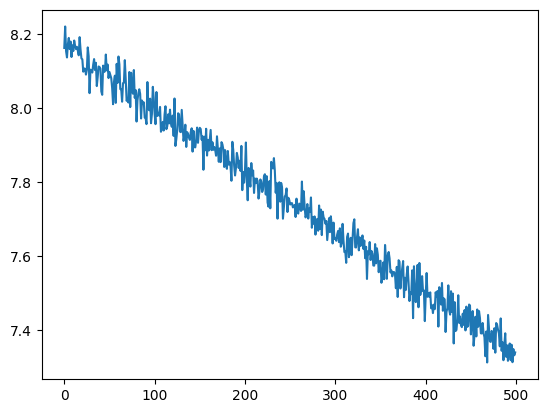

In [12]:
import matplotlib.pyplot as plt
plt.plot(loss_history)

In [15]:
input = torch.ones((1, 1), dtype=torch.long)
input = input * 10
print(input)

tensor([[10]])


In [16]:
encoded_ouput = m.generate(idx = input, max_new_tokens=10)[0].tolist()
output = decode(encoded_ouput)
print(output)

scream skin which paws explained birdcage unless flooded run until few 
